In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence, to_categorical
import fingerprint_enhancer
import random
import albumentations as A


C:\Users\kengu\AppData\Roaming\Python\Python310\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
data_dir = "./gpu_training/Mixed_Dataset"
img_size = (128, 128)
batch_size = 32
num_classes = 4

In [3]:
# Display dataset information
def display_dataset_info(data_dir):
    class_names = os.listdir(data_dir)  # List all class directories
    class_count = {class_name: len(os.listdir(os.path.join(data_dir, class_name))) for class_name in class_names}
    
    # Print the number of images in each class
    print("Dataset Class Distribution:")
    for class_name, count in class_count.items():
        print(f"{class_name}: {count} images")
    
    # Show a sample image from each class
    plt.figure(figsize=(12, 8))
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        sample_image_path = os.path.join(class_path, os.listdir(class_path)[0])  # Get the first image from the class
        
        # Read and resize the image
        img = cv2.imread(sample_image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv2.resize(img, img_size)
        
        # Display the image
        plt.subplot(2, 4, idx + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

Dataset Class Distribution:
a: 1722 images
ab: 1497 images
b: 1597 images
o: 1848 images


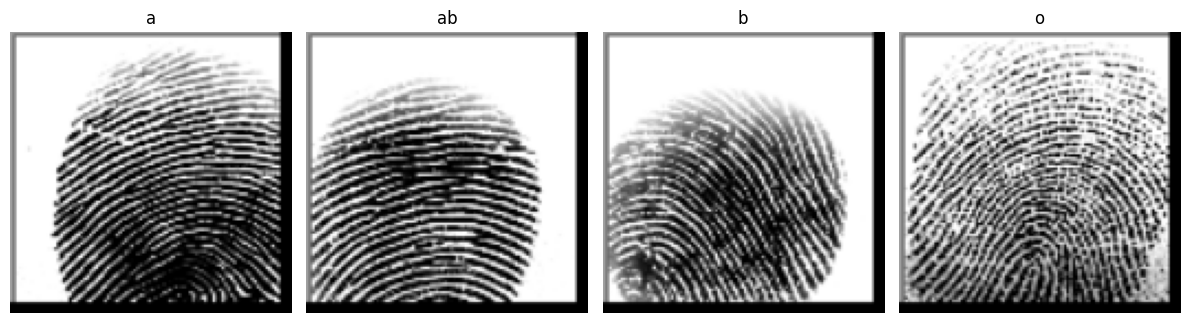

In [4]:
# Call the function to display dataset information
display_dataset_info(data_dir)

In [5]:
import cv2
import numpy as np
import random

def simple_augment(image):
    # --- Rotation ---
    angle = random.uniform(-10, 10)
    h, w = image.shape
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
    image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

    # --- Brightness ---
    brightness_factor = random.uniform(0.8, 1.2)
    image = np.clip(image * brightness_factor, 0, 255)

    # --- Contrast ---
    contrast_factor = random.uniform(0.8, 1.2)
    mean = np.mean(image)
    image = np.clip((image - mean) * contrast_factor + mean, 0, 255)

    return image.astype(np.uint8)


In [6]:
def apply_masked_processing(image):
    """
    Apply Gaussian blur and adaptive thresholding to the fingerprint region.
    More conservative approach to preserve ridge patterns.
    """
    # Step 1: Create a binary mask for the fingerprint region
    # Use a more conservative threshold to preserve more detail
    _, binary_mask = cv2.threshold(image, 180, 255, cv2.THRESH_BINARY_INV)
    
    # Step 2: Apply lighter Gaussian blur to preserve ridge details
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0.5)  # Reduced sigma
    
    # Step 3: Apply adaptive thresholding with adjusted parameters
    threshold_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 15, 8  # Increased block size and C value
    )
    
    # Step 4: Isolate the fingerprint area (where mask is white)
    enhanced_fingerprint = cv2.bitwise_and(threshold_image, threshold_image, mask=binary_mask)
    
    # Step 5: Keep the original background (where mask is black)
    background = cv2.bitwise_and(image, image, mask=cv2.bitwise_not(binary_mask))
    
    # Step 6: Combine the enhanced fingerprint and the original background
    final_image = cv2.add(enhanced_fingerprint, background)
    
    # Ensure the result has sufficient variation
    if np.std(final_image) < 5:
        print("Warning: Masked processing resulted in low variation, returning original")
        return image
    
    return final_image

In [ ]:
def preprocess_image(image_path, img_size, augment=False):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    assert image is not None, f"Could not read image: {image_path}"

    target_h, target_w = img_size
    image = cv2.equalizeHist(image)
    image = cv2.bilateralFilter(image, 5, 20, 20)
    image = apply_masked_processing(image)

    if augment:
        image = simple_augment(image)

    if np.std(image) < 10:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    work = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)

    try:
        enhanced = fingerprint_enhancer.enhance_fingerprint(work)
        if enhanced is None or np.std(enhanced) == 0:
            print(f"Warning: Enhancement failed for {image_path}, using preprocessed")
            enhanced = work
    except Exception as e:
        print(f"Warning: Enhancement error for {image_path}: {e}")
        enhanced = work

    # --- SAFETY TYPE NORMALIZATION ---
    if enhanced.dtype == bool:
        enhanced = (enhanced * 255).astype(np.uint8)
    elif enhanced.dtype != np.uint8:
        enhanced = cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # -----------------------------------

    image = cv2.resize(enhanced, (target_w, target_h), interpolation=cv2.INTER_AREA)

    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=-1)
    return image

In [8]:
class CustomImageGenerator(Sequence):
    def __init__(self, data_dir, img_size=(128, 128), batch_size=32, subset='training', validation_split=0.2, shuffle=True):
        self.data_dir = data_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.subset = subset
        self.validation_split = validation_split
        self.shuffle = shuffle
        self.class_names = sorted(os.listdir(data_dir))
        self.class_indices = {class_name: idx for idx, class_name in enumerate(self.class_names)}
        self.filepaths, self.labels = self._load_dataset()
        self.on_epoch_end()
    
    def _load_dataset(self):
        filepaths = []
        labels = []
        for class_name in self.class_names:
            class_path = os.path.join(self.data_dir, class_name)
            image_files = os.listdir(class_path)
            image_paths = [os.path.join(class_path, f) for f in image_files]
            n_total = len(image_paths)
            n_val = int(n_total * self.validation_split)
            if self.subset == 'training':
                selected = image_paths[n_val:]
            else:
                selected = image_paths[:n_val]
            filepaths.extend(selected)
            labels.extend([self.class_indices[class_name]] * len(selected))
        return filepaths, labels
    
    def __len__(self):
        return len(self.filepaths) // self.batch_size

    
    def __getitem__(self, index):
        batch_paths = self.filepaths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        images = [preprocess_image(path, self.img_size) for path in batch_paths]
        labels_one_hot = to_categorical(batch_labels, num_classes=len(self.class_names))
        
        return np.array(images), np.array(labels_one_hot)
    
    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.filepaths, self.labels))
            random.shuffle(combined)
            self.filepaths, self.labels = zip(*combined)


In [9]:
# Instantiate training and validation generators
train_gen = CustomImageGenerator(data_dir=data_dir, img_size=img_size, batch_size=batch_size, subset='training', validation_split=0.2)
val_gen = CustomImageGenerator(data_dir=data_dir, img_size=img_size, batch_size=batch_size, subset='validation', validation_split=0.2)

In [10]:
from collections import Counter

train_counts = Counter(train_gen.labels)
valid_counts = Counter(val_gen.labels)

print("Training samples per class:")
for class_idx, count in train_counts.items():
    class_name = train_gen.class_names[class_idx]
    print(f"  {class_name}: {count}")

print("Validation samples per class:")
for class_idx, count in valid_counts.items():
    class_name = val_gen.class_names[class_idx]
    print(f"  {class_name}: {count}")


Training samples per class:
  o: 1479
  a: 1378
  ab: 1198
  b: 1278
Validation samples per class:
  b: 319
  o: 369
  ab: 299
  a: 344


In [11]:
%matplotlib


Using matplotlib backend: module://matplotlib_inline.backend_inline


c:\Users\kengu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\kengu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


⚠️ Enhancement failed for cluster_3_1919.BMP: index 0 is out of bounds for axis 0 with size 0


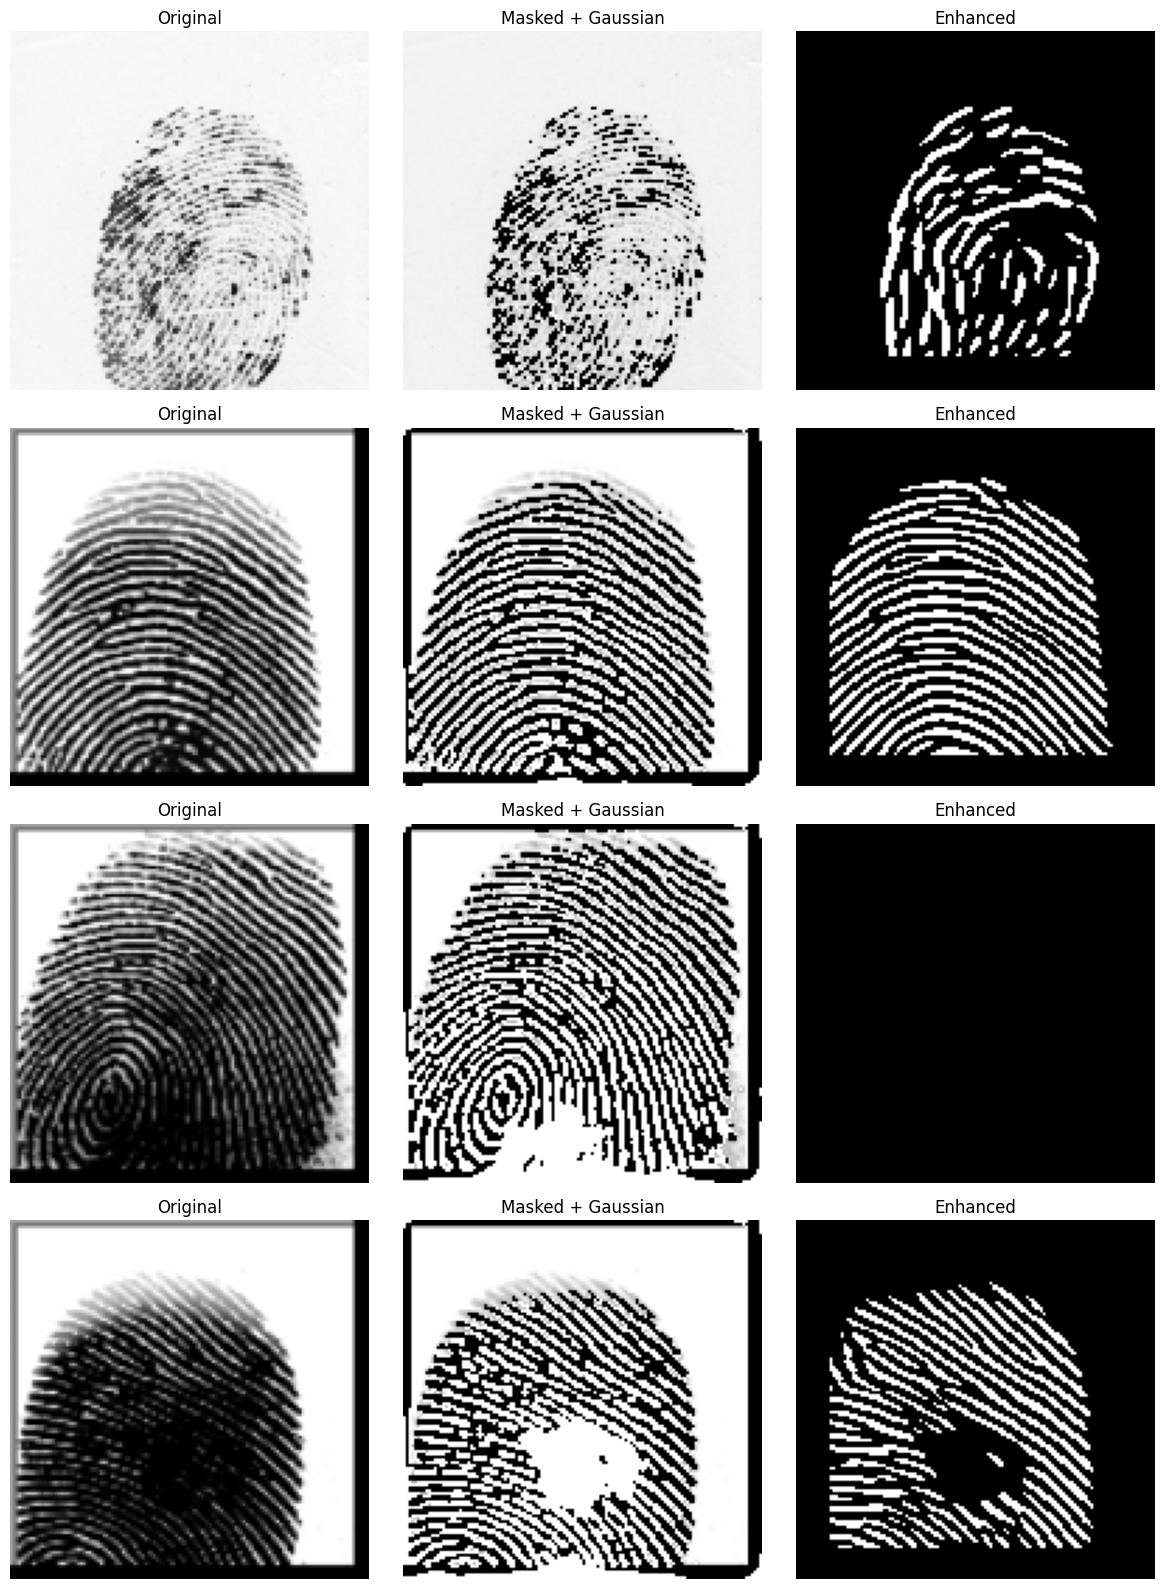

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import fingerprint_enhancer

def visualize_samples(generator, num_samples=4):
    """
    Visualize original, processed, and enhanced images from the generator.
    Skips samples that fail enhancement.
    """
    sample_paths = random.sample(generator.filepaths, num_samples)
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    
    for i, img_path in enumerate(sample_paths):
        img_orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_orig = cv2.resize(img_orig, generator.img_size)

        # Apply preprocessing/masking
        img_processed = apply_masked_processing(img_orig)
        
        # Normalize before enhancement
        img_norm = cv2.normalize(img_processed, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        try:
            img_enhanced = fingerprint_enhancer.enhance_fingerprint(img_norm)
            img_enhanced = (img_enhanced * 255).astype(np.uint8)
        except Exception as e:
            print(f"⚠️ Enhancement failed for {os.path.basename(img_path)}: {e}")
            img_enhanced = np.zeros_like(img_norm)  # fallback blank

        # Plot
        axes[i, 0].imshow(img_orig, cmap='gray')
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(img_processed, cmap='gray')
        axes[i, 1].set_title('Masked + Gaussian')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(img_enhanced, cmap='gray')
        axes[i, 2].set_title('Enhanced')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


# Visualize samples from the training generator
visualize_samples(train_gen, num_samples=4)

In [13]:
# Check the class indices mapping
print("Class Indices Mapping:", train_gen.class_indices)

Class Indices Mapping: {'a': 0, 'ab': 1, 'b': 2, 'o': 3}


In [14]:
print("Class Indices Mapping:", val_gen.class_indices)


Class Indices Mapping: {'a': 0, 'ab': 1, 'b': 2, 'o': 3}


In [15]:
from sklearn.utils import class_weight
import numpy as np

# Use train_gen.labels instead of train_gen.classes
class_labels = np.array(train_gen.labels)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

# Optional: Map weights to class indices
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)


Class weights: {0: 0.9675253991291727, 1: 1.1128964941569282, 2: 1.0432316118935838, 3: 0.9014536849222448}


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Build a Convolutional Neural Network (CNN) Model
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(img_size[0], img_size[1], 1)),
    BatchNormalization(),  # Normalize activations after convolution
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation="relu"),
    BatchNormalization(),  # Normalizing dense layer activations
    Dropout(0.5),  # Regularization to prevent overfitting

    Dense(num_classes, activation="softmax")  # Output layer
])


c:\Users\kengu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Compile the model (use categorical crossentropy instead of focal loss for balanced classes)
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # safer LR (1e-4)
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [18]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,988 (12.61 MB)

 Trainable params: 3,305,284 (12.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [19]:
# Callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [20]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [21]:
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',   # saved file name
    monitor='val_accuracy',     # metric to monitor
    save_best_only=True,        # only save the best model
    mode='max',
    verbose=1
)

In [22]:
steps_per_epoch = len(train_gen)
validation_steps = len(val_gen)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,                        # increased for better learning
    class_weight=class_weights_dict,  # keeps dataset balanced
    callbacks=[reduce_lr, early_stopping, checkpoint],
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    verbose=1
)

c:\Users\kengu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - accuracy: 0.6308 - loss: 1.0706 
Epoch 1: val_accuracy improved from -inf to 0.24085, saving model to best_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 7580s 46s/step - accuracy: 0.6312 - loss: 1.0695 - val_accuracy: 0.2409 - val_loss: 5.0934 - learning_rate: 1.0000e-04
Epoch 2/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.7888 - loss: 0.5565 
Epoch 2: val_accuracy improved from 0.24085 to 0.36128, saving model to best_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 6854s 41s/step - accuracy: 0.7888 - loss: 0.5564 - val_accuracy: 0.3613 - val_loss: 3.1002 - learning_rate: 1.0000e-04
Epoch 3/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.8570 - loss: 0.3736 
Epoch 3: val_accuracy improved from 0.36128 to 0.58841, saving model to best_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 6565s 40s/step - accuracy: 0.8570 - loss: 0.3737 - val_accuracy: 0.5884 - val_loss: 1.0513 - learning_rate: 1.0000e-04
Epoch 4/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.8962 - loss: 0.2644 
Epoch 4: val_accuracy improved from 0.58841 to 0.79268, saving model to best_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 6570s 40s/step - accuracy: 0.8962 - loss: 0.2644 - val_accuracy: 0.7927 - val_loss: 0.5087 - learning_rate: 1.0000e-04
Epoch 5/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.9487 - loss: 0.1592 
Epoch 5: val_accuracy improved from 0.79268 to 0.87424, saving model to best_model.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 6553s 40s/step - accuracy: 0.9487 - loss: 0.1592 - val_accuracy: 0.8742 - val_loss: 0.3170 - learning_rate: 1.0000e-04
Epoch 6/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.9708 - loss: 0.1175 
Epoch 6: val_accuracy did not improve from 0.87424
166/166 ━━━━━━━━━━━━━━━━━━━━ 6552s 40s/step - accuracy: 0.9707 - loss: 0.1175 - val_accuracy: 0.8041 - val_loss: 0.5422 - learning_rate: 1.0000e-04
Epoch 7/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.9818 - loss: 0.0847 
Epoch 7: val_accuracy did not improve from 0.87424
166/166 ━━━━━━━━━━━━━━━━━━━━ 6773s 41s/step - accuracy: 0.9818 - loss: 0.0847 - val_accuracy: 0.8407 - val_loss: 0.4195 - learning_rate: 1.0000e-04
Epoch 8/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.9884 - loss: 0.0579 
Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 8: val_accuracy did not improve from 0.87424
166/166 ━━━━━━━━━━━━━━━━━━━━ 6858s 41s/step - accuracy: 0.9884 - 

In [23]:
# Example for a Keras Sequence or generator
batch = next(iter(train_gen))
print("Batch type:", type(batch))
print("Batch length:", len(batch))
print("X batch shape:", batch[0].shape)
print("y batch shape:", batch[1].shape)


Batch type: <class 'tuple'>
Batch length: 2
X batch shape: (32, 128, 128, 1)
y batch shape: (32, 4)


In [24]:
batch_val = next(iter(val_gen))
print("Validation batch X shape:", batch_val[0].shape)
print("Validation batch y shape:", batch_val[1].shape)


Validation batch X shape: (32, 128, 128, 1)
Validation batch y shape: (32, 4)


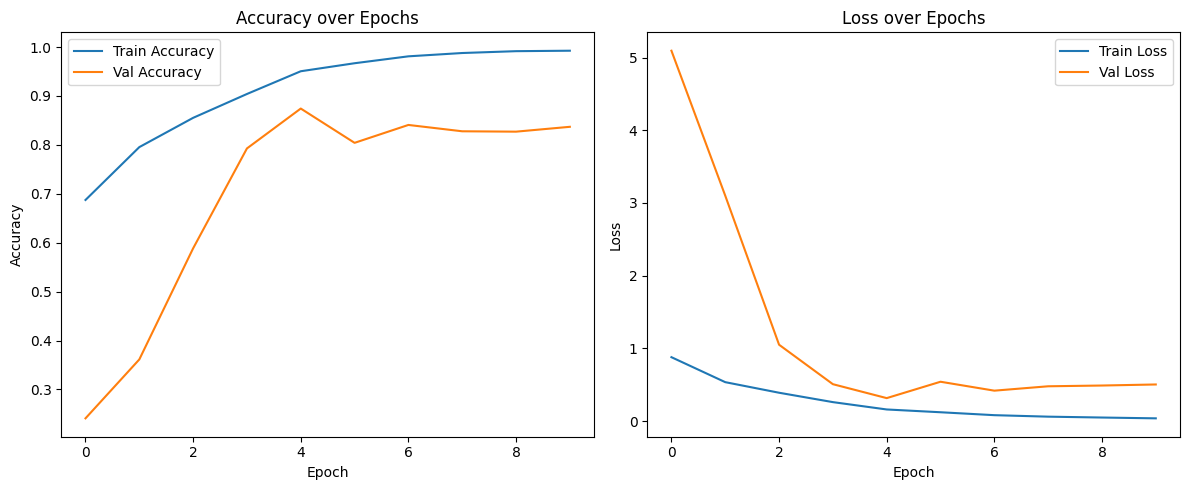

In [25]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [26]:
import numpy as np

# Get ground truth labels
y_true = []
y_pred = []

for i in range(len(val_gen)):
    X_batch, y_batch = val_gen[i]
    preds = model.predict(X_batch, verbose=0)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

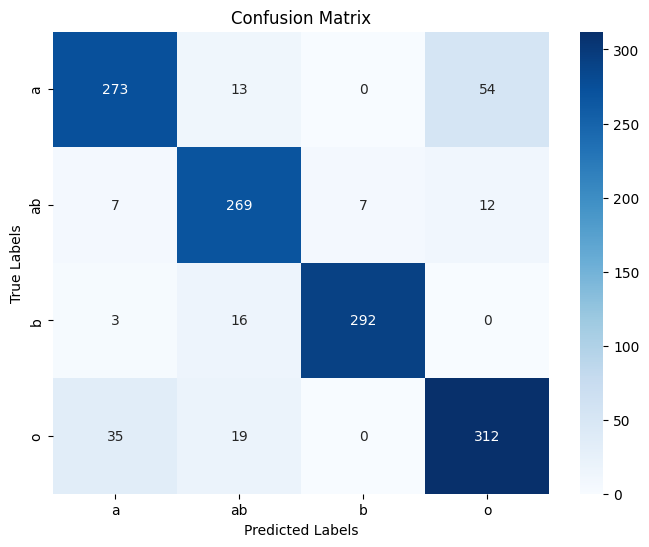

Classification Report:
              precision    recall  f1-score   support

           a       0.86      0.80      0.83       340
          ab       0.85      0.91      0.88       295
           b       0.98      0.94      0.96       311
           o       0.83      0.85      0.84       366

    accuracy                           0.87      1312
   macro avg       0.88      0.88      0.88      1312
weighted avg       0.88      0.87      0.87      1312



In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = val_gen.class_names

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [1]:
import tensorflow as tf
model = tf.keras.models.load_model('best_model.h5')

In [2]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\kengu\AppData\Local\Temp\tmphc9rac6f\assets


INFO:tensorflow:Assets written to: C:\Users\kengu\AppData\Local\Temp\tmphc9rac6f\assets


Saved artifact at 'C:\Users\kengu\AppData\Local\Temp\tmphc9rac6f'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2836270598800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2836270603728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2836270861824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2836270863936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2836270611296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2836270859536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2836270872384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2836270873088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2836270878384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2836270880144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  283627

In [3]:
with open('fingerprint-model-128.tflite', 'wb') as f:
    f.write(tflite_model)